# Simple gene regulatory networks

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la
import ladynamic as lad

In [2]:
import networkx as nx

In [3]:
genes = la.Dim(5, "gene")
proteins = la.Dim(range(len(genes)), "protein")

In [4]:
mrna_initial = la.Fixed(1.)
protein_initial = la.Fixed(0.)
transcription_maximal = la.Fixed(np.array([0., 10., 20., 30., 40.]), definition = la.Definition([genes]))
degradation = la.Fixed(np.array([1., 1., 1., 1., 1.]), definition = la.Definition([genes]))

In [5]:
mrna = lad.State(mrna_initial, definition = la.Definition([genes]), label = "mrna")
protein = lad.State(mrna_initial, definition = la.Definition([genes]), label = "protein")

In [6]:
class dmrna(la.Computed):
    transcription_maximal = la.variables.VariablePromise("transcription_maximal", r"\textit{transcription}_{max}")
    degradation = la.variables.VariablePromise("degradation")
    mrna = la.variables.VariablePromise("mrna")
    def __call__(self, transcription_maximal, degradation, mrna):
        return transcription_maximal - degradation * mrna
    
class dprotein(la.Computed):
    mrna = la.variables.VariablePromise(dims = la.variables.promise.ParentSwitched("transcript_dim", "protein_dim"))
    protein = la.variables.VariablePromise(dims = la.variables.promise.ParentSwitched("protein_dim", "transcript_dim"))
    
    def __init__(self, mrna, protein, *args, definition = None ,**kwargs):
        self.transcript_dim = mrna[-1]
        self.protein_dim = protein[-1]
        
        definition = mrna.clean.contract(mrna[-1]).expand_right(protein[-1])
        super().__init__(*args, definition = definition, **kwargs)
        
    def __call__(self, mrna, protein):
        return protein - mrna

In [7]:
mrna.derivative = dmrna(transcription_maximal, degradation, mrna)
protein.derivative = dprotein(mrna, protein)


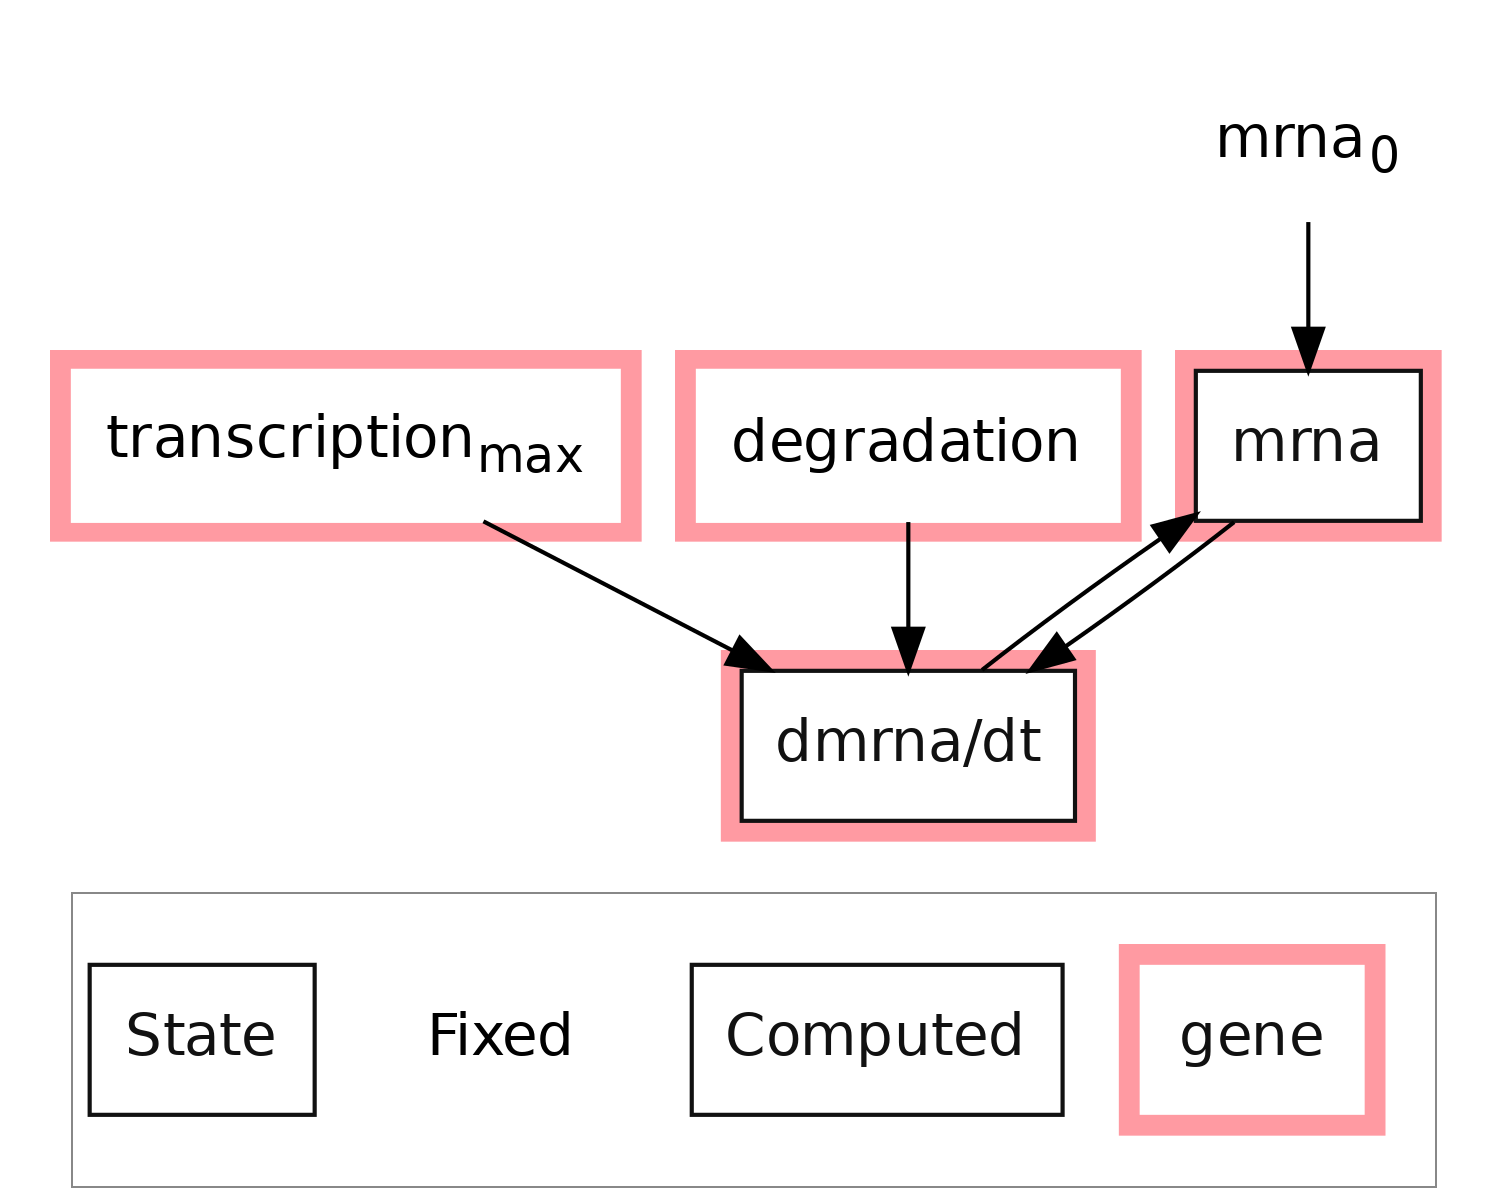

In [8]:
mrna.plot()

In [9]:
dt = la.Fixed(0.01)
final_time = la.Fixed(10.)
delta_time = la.Fixed(1.)
mrna_extractor = lad.extractors.DeltaExtractor(mrna, final_time, delta_time)

extractors = [mrna_extractor]

In [10]:
states = [mrna]
dynamics = lad.solvers.Euler(states, extractors, dt)

In [11]:
time = dynamics.time
time_extractor = lad.extractors.DeltaExtractor(time, final_time, delta_time)
dynamics.add_extractors(time_extractor)

In [12]:
dispersion = la.Fixed(0.01)
counts = la.distributions.NegativeBinomial2(mrna_extractor, dispersion)


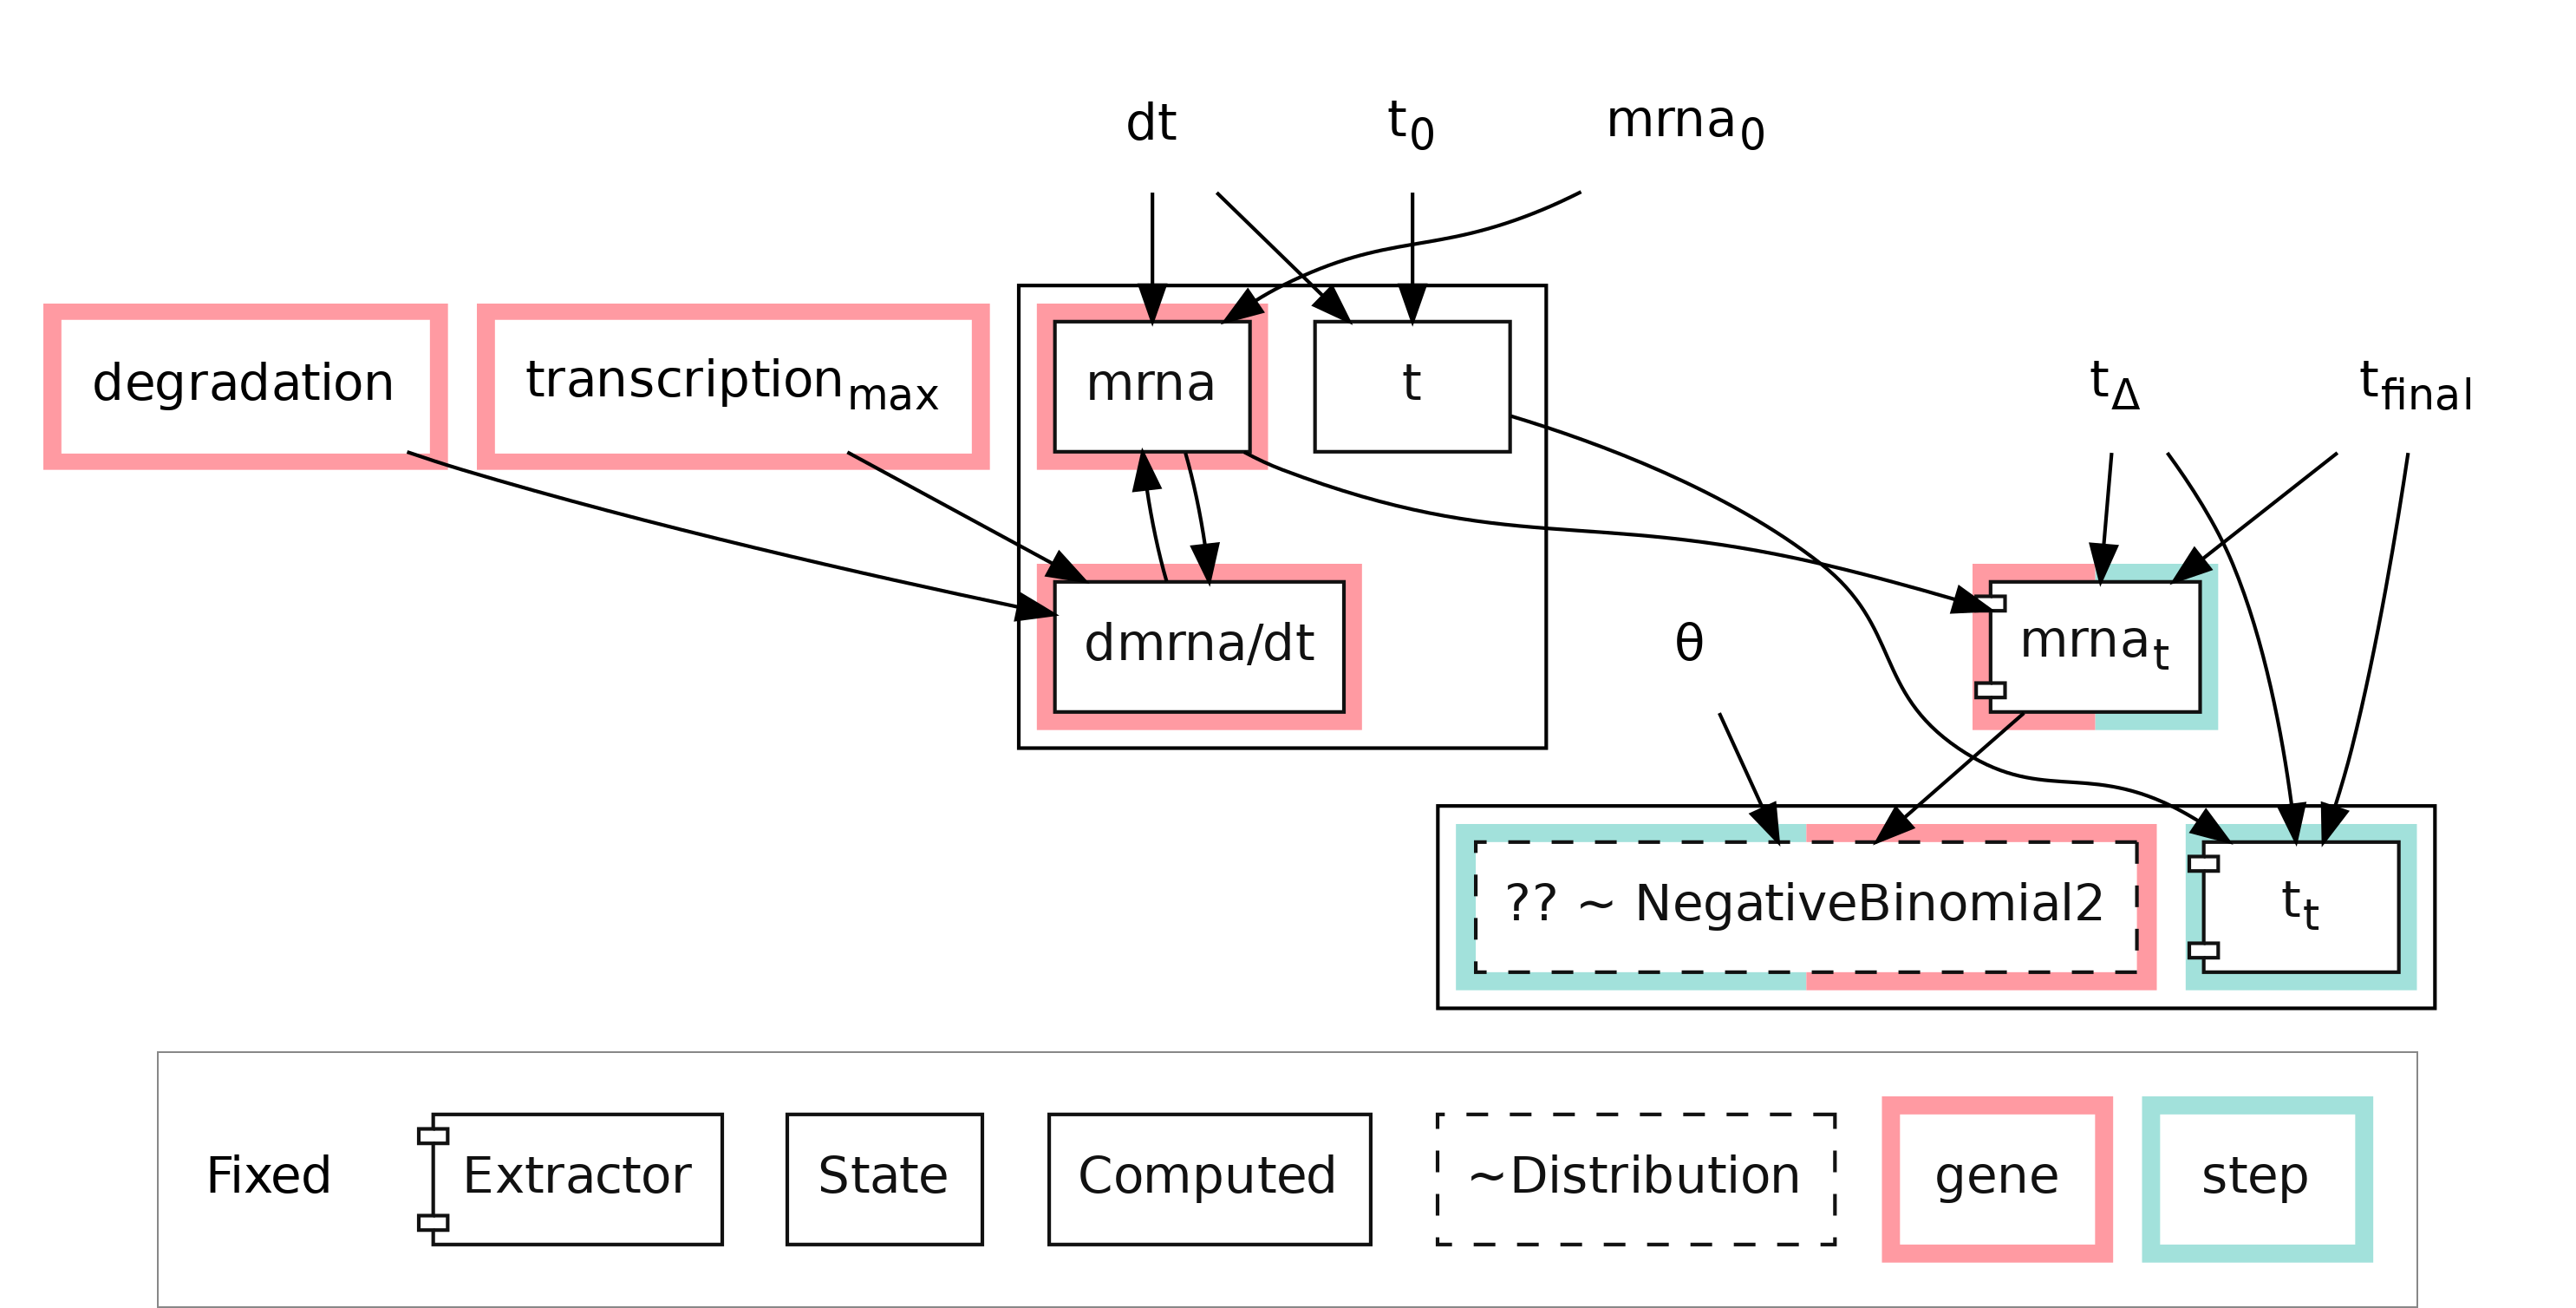

In [13]:
model = la.Model(counts = counts, time = time_extractor)
model.plot()

In [19]:
posterior = la.posterior.Posterior(model, batch_dim = "", retain_samples = {time_extractor, mrna_extractor, counts, counts.mu})
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
time_values = posterior.samples[time_extractor].sel(sample = 0).broadcast_like(posterior.samples[mrna_extractor].sel(sample = 0))
steps = xr.concat([
    posterior.samples[counts].sel(sample = 0),
    posterior.samples[counts.mu].sel(sample = 0),
    time_values
], dim = pd.Series(["counts", "expression", "time"], name = "state"))

In [21]:
sns.set_palette("Set1", 8, .75)

In [22]:
import matplotlib as mpl

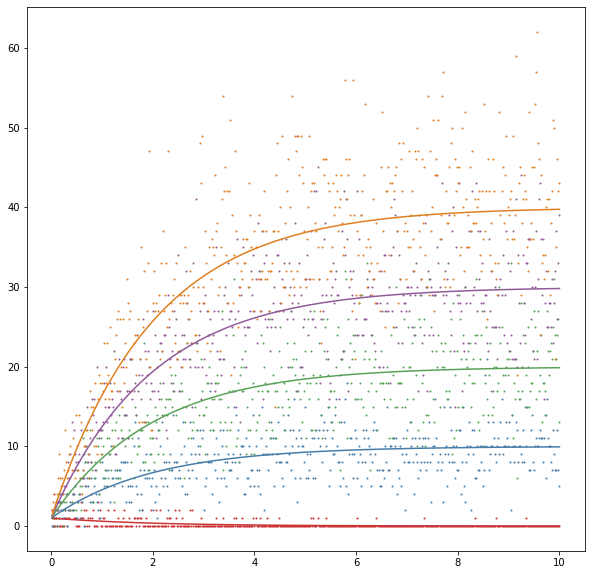

In [23]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
for gene_id in genes.index:
    plotdata = steps.sel(gene = gene_id).to_pandas().T
    ax.scatter(plotdata["time"], plotdata["counts"], s = 1)
    ax.plot(plotdata["time"], plotdata["expression"])

In [25]:
last_step = posterior.samples[counts].coords["step"][-1]
counts_value = posterior.samples[counts].sel(step = last_step).to_pandas()

In [83]:
counts_value.index = pd.Series(counts_value.index, name = "cell")

## Optimizing dynamic parameters

In [26]:
mrna_initial = la.Fixed(1.)
# transcription_maximal = la.Parameter(10., definition = la.Definition([genes]), transforms=[la.transforms.Exp()])
transcription_maximal = la.Latent(la.distributions.LogNormal(), definition = la.Definition([genes]))
# transcription_maximal = la.Fixed(10., definition = la.Definition([genes]), transforms=[la.transforms.Exp()])
degradation = la.Fixed(np.array([1., 1., 1., 1., 1.]), definition = la.Definition([genes]))

In [27]:
mrna = lad.State(mrna_initial, definition = la.Definition([genes]), label = "mrna")

In [28]:
mrna.derivative = dmrna(transcription_maximal, degradation, mrna)

In [29]:
mrna_extractor = lad.extractors.FinalExtractor(mrna, final_time)

extractors = [mrna_extractor]

In [30]:
states = [mrna]
dynamics = lad.solvers.Euler(states, extractors, dt)

In [31]:
counts_p = la.distributions.NegativeBinomial2(mrna_extractor, dispersion, definition = la.Definition.from_xr(counts_value))

In [32]:
counts = la.Observation(counts_value, counts_p, label = "counts")


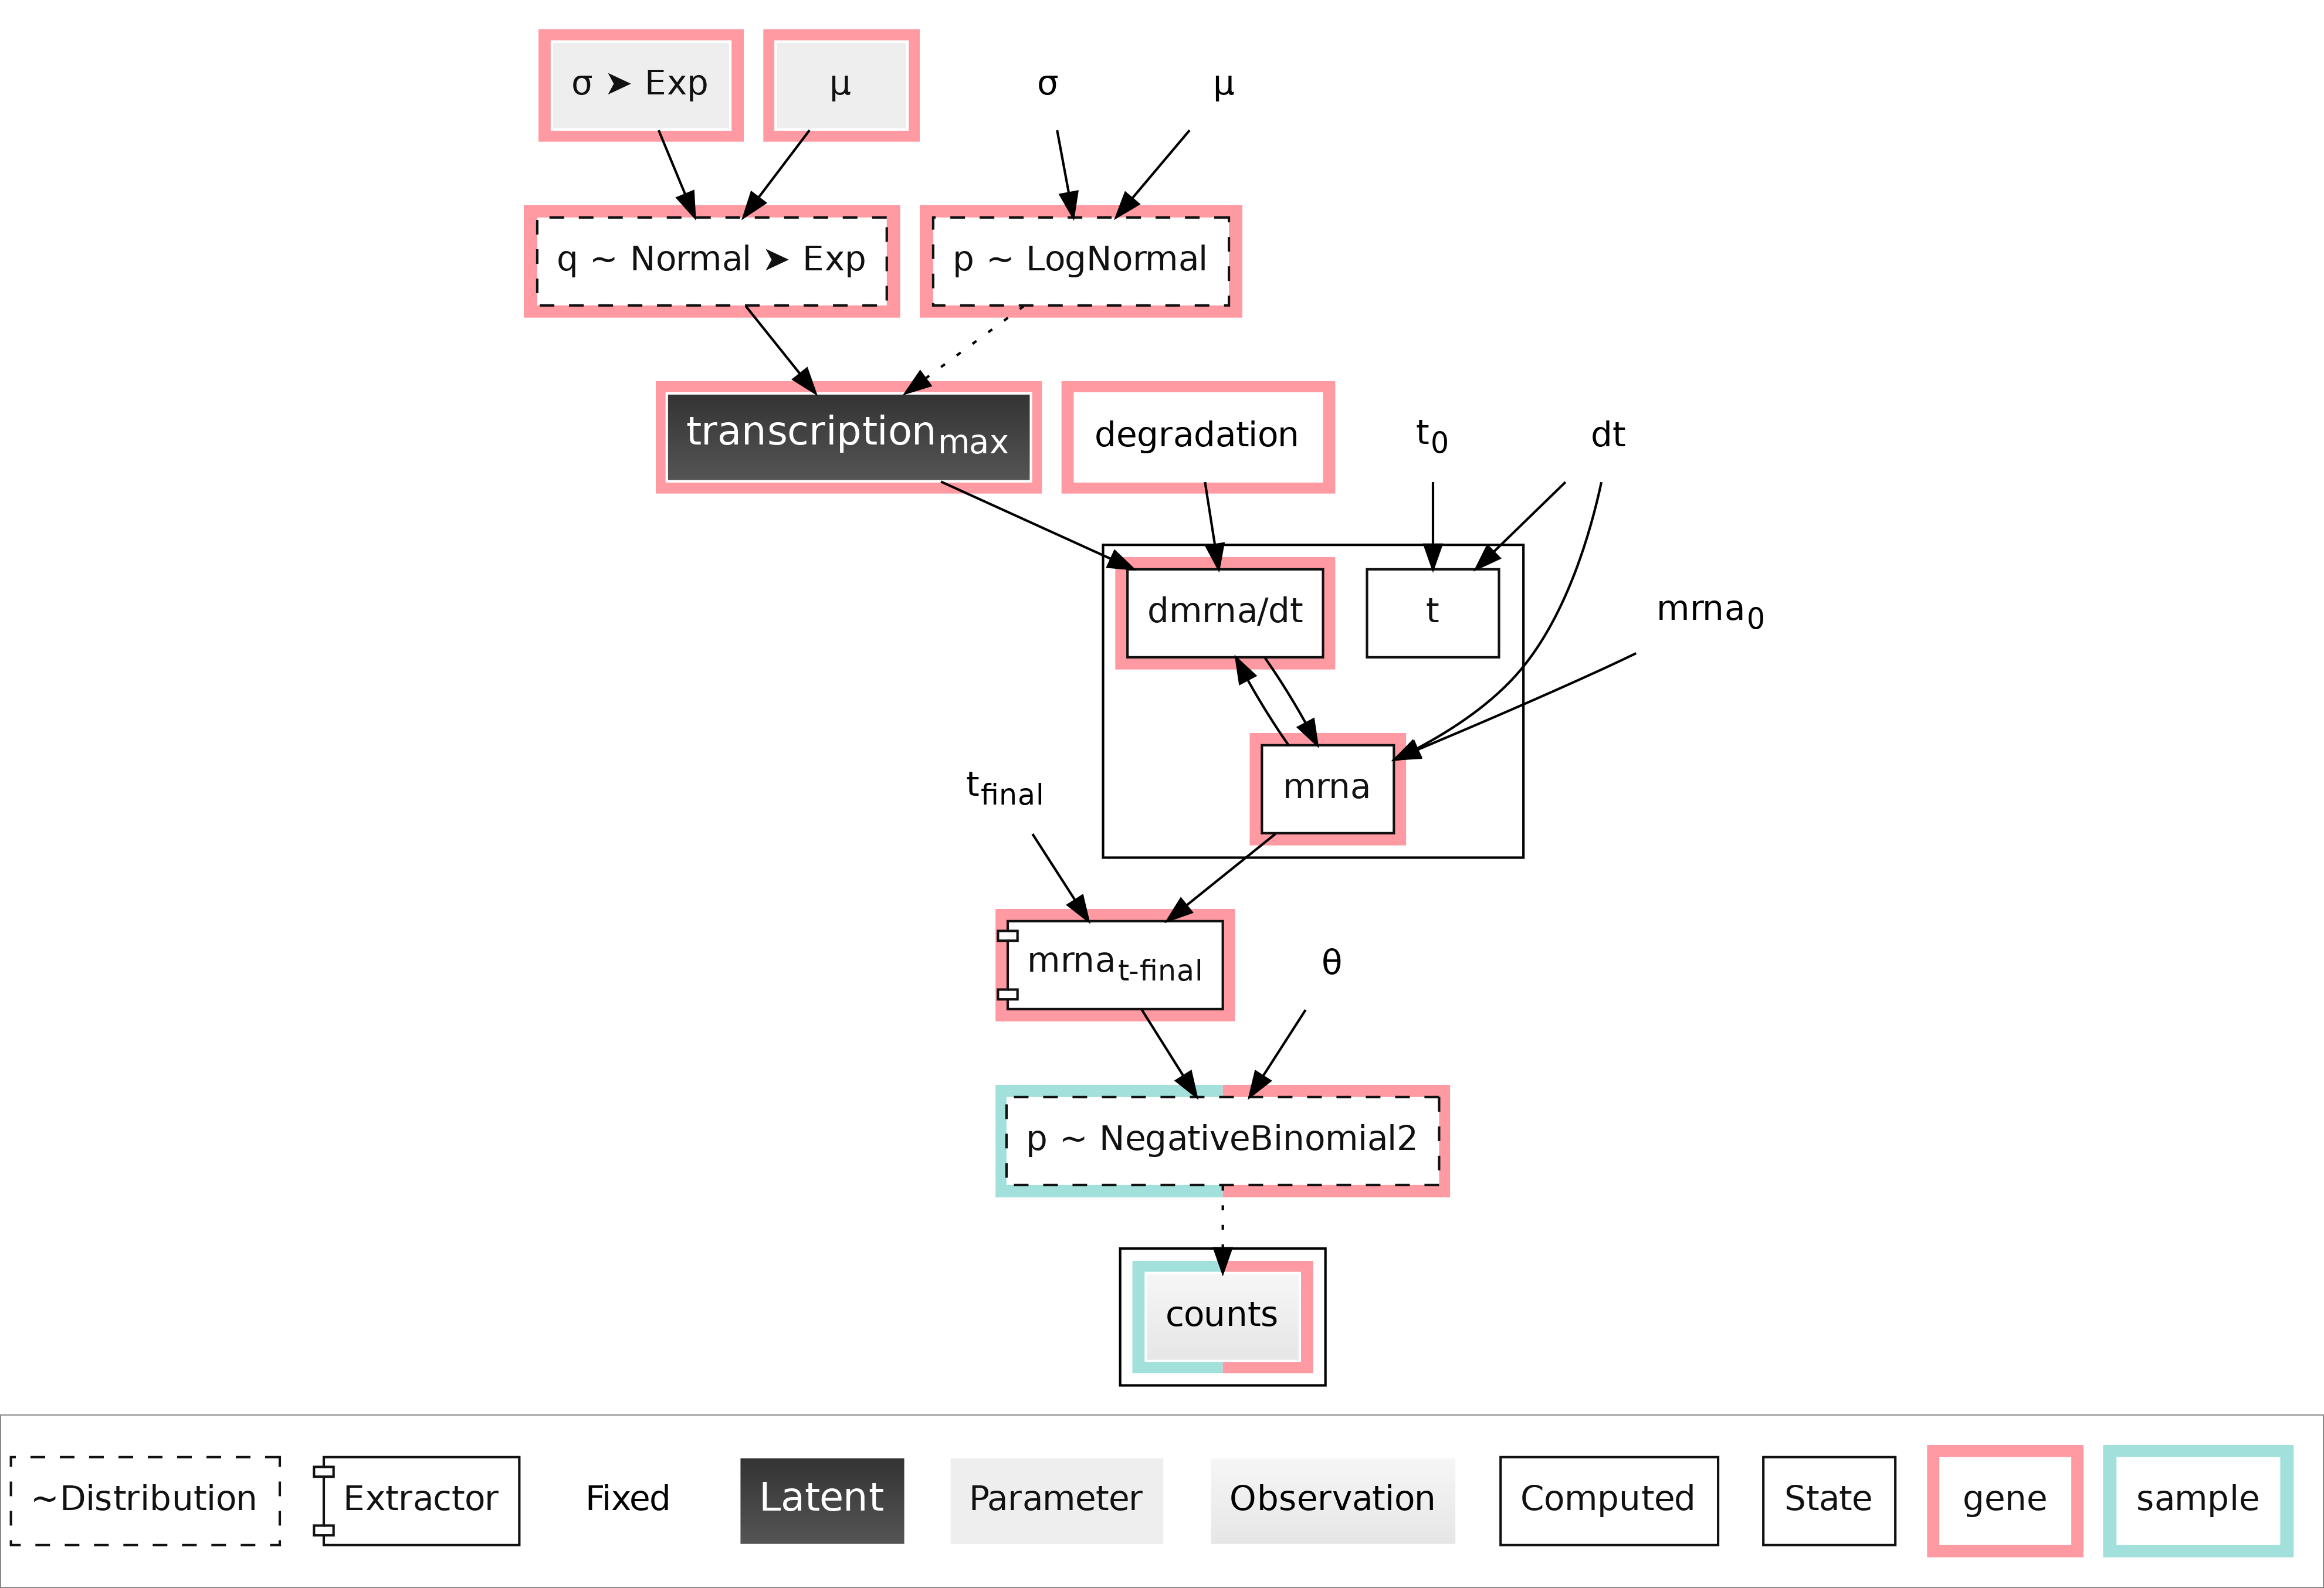

In [33]:
model = la.Model(counts)
model.plot()

  0%|                                                                                                         …

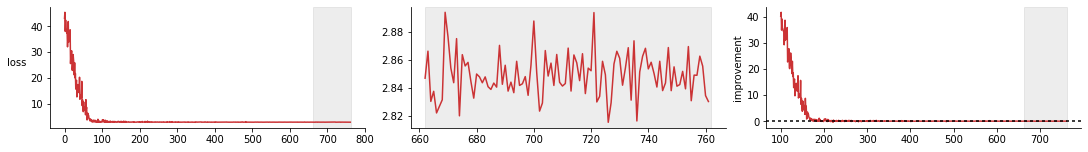

In [34]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.05))
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(1000)
trace.plot();

In [35]:
posterior = la.posterior.Posterior(model)
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]